In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torchvision

if not os.path.exists('resultsGAN'):
    os.mkdir('resultsGAN')

batch_size = 100
latent_size = 20

device = 'cpu'

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./files', train=True, download=True,
                   transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Lambda((lambda x: torch.flatten(x))),
                            ])),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./files', train=False, 
                   transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Lambda((lambda x: torch.flatten(x))),
                            ])),
    batch_size=batch_size, shuffle=True)

In [2]:
class Generator(nn.Module):
    #The generator takes an input of size latent_size, and will produce an output of size 784.
    #It should have a single hidden linear layer with 400 nodes using ReLU activations, 
    #and use Sigmoid activation for its outputs
    def __init__(self):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(latent_size, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid(),
        )
        self.G_loss_fcn = nn.BCELoss()

    def forward(self, z):
        return self.gen(z)

class Discriminator(nn.Module):
    #The discriminator takes an input of size 784, and will produce an output of size 1.
    #It should have a single hidden linear layer with 400 nodes using ReLU activations, 
    #and use Sigmoid activation for its output
    def __init__(self):
        super(Discriminator, self).__init__()
        self.dis = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Linear(400,1),
            nn.Sigmoid(),
        )
        self.D_loss_fcn = nn.BCELoss()

    def forward(self, x):
        return self.dis(x).squeeze()

In [3]:
def train(generator, generator_optimizer, discriminator, discriminator_optimizer):
    #Trains both the generator and discriminator for one epoch on the training dataset.
    #Returns the average generator and discriminator loss (scalar values, use the binary cross-entropy appropriately)
    #TODO
    generator.train()
    discriminator.train()
    
    avg_generator_loss = 0
    avg_discriminator_loss = 0
    total = 0
    
    for x, t in train_loader:
        bs = len(t)
        z = torch.normal(torch.zeros((bs, latent_size)), 1.) # seed
        x_gen = generator(z) #fake image
        f_label = torch.zeros((bs,))
        r_label = torch.ones((bs,))
        
        r_y = discriminator(x) # real label learning
        f_y = discriminator(x_gen)
        # D learning
        loss_D1 = discriminator.D_loss_fcn(r_y, r_label)
        loss_D2 = discriminator.D_loss_fcn(f_y, f_label)
        discriminator_optimizer.zero_grad()
        loss_D1.backward()
        loss_D2.backward()
        loss_D = loss_D1 + loss_D2
        discriminator_optimizer.step()
        
        z = torch.normal(torch.zeros((bs, latent_size)), 1.) # seeds
        y_gen = discriminator( generator(z) ) # FF 
        loss_G = generator.G_loss_fcn(y_gen, torch.ones((bs,))) 
        generator_optimizer.zero_grad()
        loss_G.backward()
        generator_optimizer.step()

        avg_generator_loss += loss_G*len(t)
        avg_discriminator_loss += loss_D*len(t)
        total += len(t)

    return avg_generator_loss/total, avg_discriminator_loss/total

def test(generator, discriminator):
    generator.eval()
    discriminator.eval()
    
    avg_generator_loss = 0
    avg_discriminator_loss = 0
    total = 0

    for x, t in test_loader:
        bs = len(t)
        z = torch.normal(torch.zeros((bs, latent_size)), 1.) # seed
        x_gen = generator(z) #fake image
        f_label = torch.zeros((bs,))
        r_label = torch.ones((bs,))
        
        r_y = discriminator(x) # real label learning
        f_y = discriminator(x_gen)
        # D learning
        loss_D1 = discriminator.D_loss_fcn(r_y, r_label)
        loss_D2 = discriminator.D_loss_fcn(f_y, f_label)

        loss_D = loss_D1 + loss_D2
        
        z = torch.normal(torch.zeros((bs, latent_size)), 1.) # seeds
        y_gen = discriminator( generator(z) ) # FF 
        loss_G = generator.G_loss_fcn(y_gen, torch.ones((bs,))) 

        avg_generator_loss += loss_G*len(t)
        avg_discriminator_loss += loss_D*len(t)
        total += len(t)

    return avg_generator_loss/total, avg_discriminator_loss/total

Epoch #1


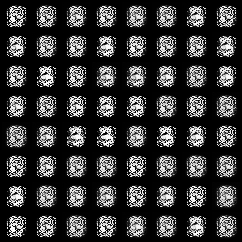



Epoch #2


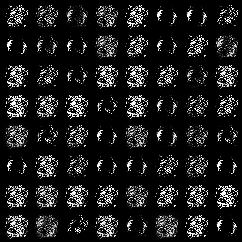



Epoch #3


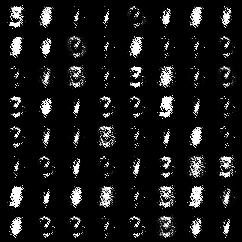



Epoch #4


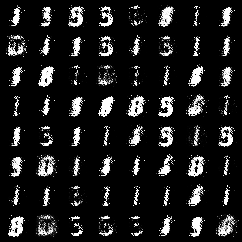



Epoch #5


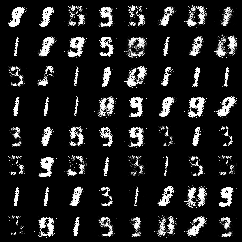



Epoch #6


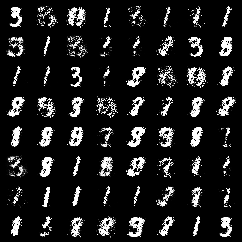



Epoch #7


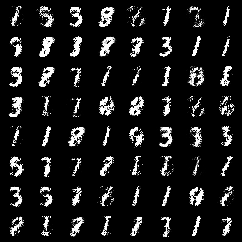



Epoch #8


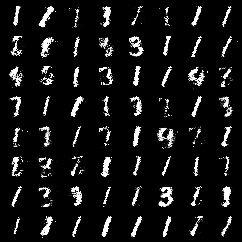



Epoch #9


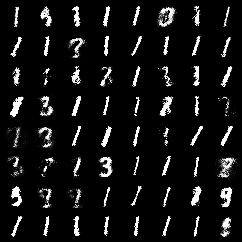



Epoch #10


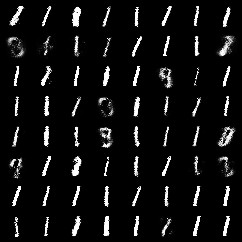



Epoch #11


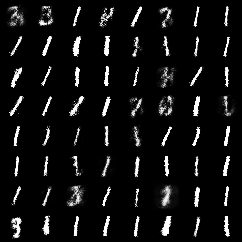



Epoch #12


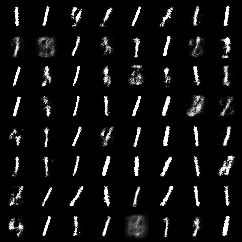



Epoch #13


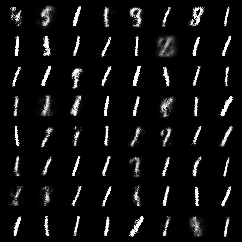



Epoch #14


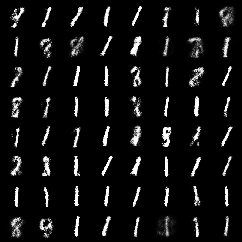



Epoch #15


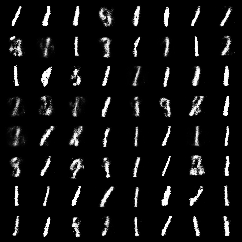



Epoch #16


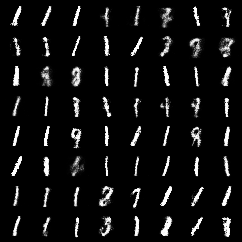



Epoch #17


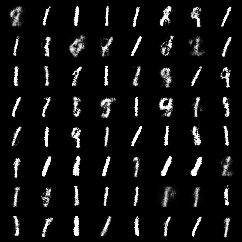



Epoch #18


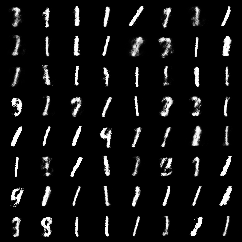



Epoch #19


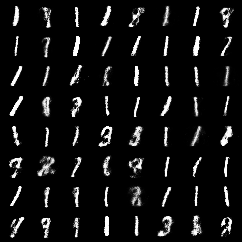



Epoch #20


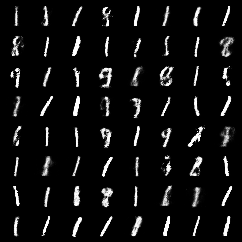



Epoch #21


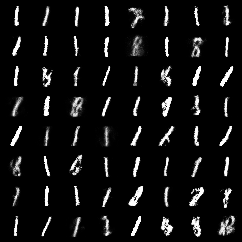



Epoch #22


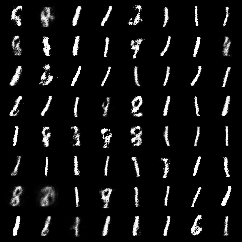



Epoch #23


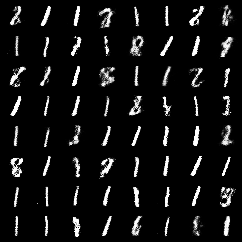



Epoch #24


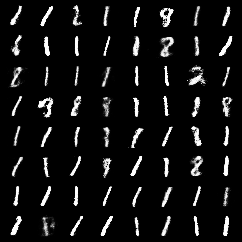



Epoch #25


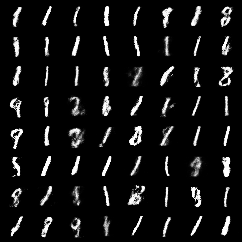



Epoch #26


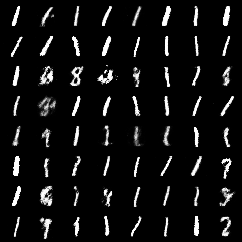



Epoch #27


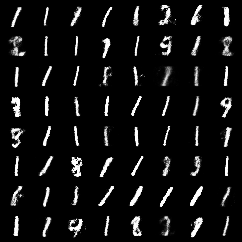



Epoch #28


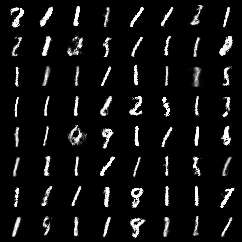



Epoch #29


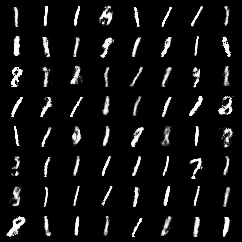



Epoch #30


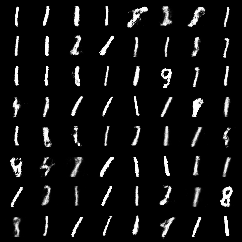

In [4]:
epochs = 30

discriminator_avg_train_losses = []
discriminator_avg_test_losses = []
generator_avg_train_losses = []
generator_avg_test_losses = []

generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator_optimizer = optim.Adam(generator.parameters(), lr=1e-3)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-3)

for epoch in range(1, epochs + 1):
    generator_avg_train_loss, discriminator_avg_train_loss = train(generator, generator_optimizer, discriminator, discriminator_optimizer)
    generator_avg_test_loss, discriminator_avg_test_loss = test(generator, discriminator)

    discriminator_avg_train_losses.append(discriminator_avg_train_loss)
    generator_avg_train_losses.append(generator_avg_train_loss)
    discriminator_avg_test_losses.append(discriminator_avg_test_loss)
    generator_avg_test_losses.append(generator_avg_test_loss)

    with torch.no_grad():
        sample = torch.randn(64, latent_size).to(device)
        sample = generator(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'resultsGAN/sample_' + str(epoch) + '.png')
        print('Epoch #' + str(epoch))
        display(Image('resultsGAN/sample_' + str(epoch) + '.png'))
        print('\n')

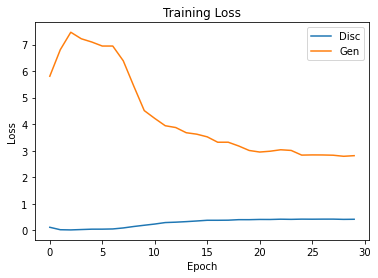

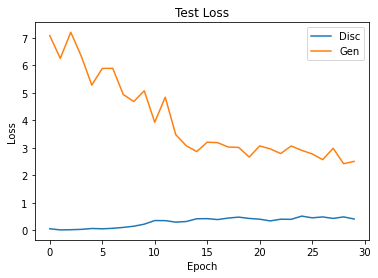

In [5]:
plt.plot(torch.Tensor(discriminator_avg_train_losses))
plt.plot(torch.Tensor(generator_avg_train_losses))
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Disc','Gen'], loc='upper right')
plt.show()

plt.plot(torch.Tensor(discriminator_avg_test_losses))
plt.plot(torch.Tensor(generator_avg_test_losses))
plt.title('Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Disc','Gen'], loc='upper right')
plt.show()